<a href="https://colab.research.google.com/github/sota1111/DL_Zero4/blob/main/DL_Zero4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install numpy matplotlib ipython scikit-learn pandas pillow dezero gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from dezero import Variable

In [32]:
!apt update
!apt install xvfb

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Err:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
  Could not connect to ppa.launchpad.net:80 (185.125.190.52), connection timed out
Err:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
  Unable to connect to ppa.launchpad.net:http:
Err:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
  Unable to connect to ppa.

In [33]:
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display

d = Display()
d.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
!apt update && apt install xvfb
!pip install gym-notebook-wrapper

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Err:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
  Could not connect to ppa.launchpad.net:80 (185.125.190.52), connection timed out
Err:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
  Unable to connect to ppa.launchpad.net:http:
Err:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
  Unable to connect to ppa.

# 8章 DQN
DQN：Q学習とニューラルネットワークを使った手法。  
前章から「経験再生」と「ターゲットネットワーク」が使われる。  

## 8.1 OpenAI Gym

### 8.1.1 OpenAI Gymの基礎知識

In [35]:
import gym
env = gym.make('CartPole-v0')

state = env.reset()
print(state)

action_space = env.action_space
print(action_space)

[-0.03399667  0.02160338  0.03024511 -0.04416603]
Discrete(2)


In [36]:
action = 0
next_state, reward, done, info = env.step(action)
print(next_state)

[-0.0335646  -0.17393893  0.02936179  0.25790399]


### 8.1.2 ランダムなエージェント

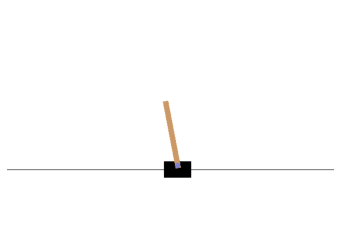

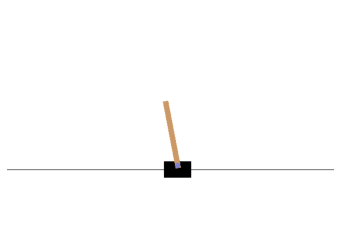

In [37]:
import gnwrapper
import gym
import numpy as np

env = gym.make('CartPole-v0')
env_gnw = gnwrapper.Animation(env) # Xvfbが起動される

state = env.reset()
done = False

while not done:
  env_gnw.render() # ここで、前の描画を消し、新しいステップの描画を行う。
  action = np.random.choice([0, 1])
  next_state, reward, done, info = env.step(action) # 本当はDNNからアクションを入れる
env.close()

## 8.2 DQNのコア技術
DQNはニューラルネットワークの学習を安定させるために、経験再生とターゲットネットワークという技術を使う。

### 8.2.1 経験再生
エージェントが経験したデータをバッファに保存し、Q関数を更新する際には、そのバッファから経験データをランダムに取り出して使う。  
経験再生によって、経験データ間の相関が弱まり、偏りの少ないデータが得られる。さらに、経験データを繰り返し使うことができるため、データ効率が良くなる。

### 8.2.2 経験再生の実装

In [38]:
from collections import deque
import random
import numpy as np

class ReplayBuffer:
  def __init__(self, buffer_size, batch_size):
    self.buffer = deque(maxlen=buffer_size)
    self.batch_size = batch_size

  def add(self, state, action, reward, next_state, done):
    data = (state, action, reward, next_state, done)
    self.buffer.append(data)

  def __len__(self):
    return len(self.buffer)
  
  def get_batch(self):
    data = random.sample(self.buffer, self.batch_size)

    state = np.stack([x[0] for x in data])
    action = np.array([x[1] for x in data])
    reward = np.array([x[2] for x in data])
    next_state = np.stack([x[3] for x in data])
    done = np.array([x[4] for x in data]).astype(np.int32)
    return state, action, reward, next_state, done


In [39]:
import gym

env = gym.make('CartPole-v0')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
  state = env.reset()
  done = False

  while not done:
    action = 0
    next_state, reward, done, info = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape)
print(action.shape)
print(reward.shape)
print(next_state.shape)
print(done.shape)


(32, 4)
(32,)
(32,)
(32, 4)
(32,)


### 8.2.1 ターゲットネットワーク
Q学習では、Q (St、At)の値がRt+r*maxQ(St+1, α)：TDターゲット　  
となるようにQ関数を更新する。TDターゲットの値は、Q関数が更新されると変動する。これを固定する。  
オリジナルのネットワークqnetと同じ構造のネットワークqnet_targetを用意し、定期的にqnetの重みと同期するようにして、それ以外は重みパラメータを固定する。  
qnet_targetを使って、TDターゲットの値を計算すれば、教師レベルであるTDターゲットの変動が抑えられる。これにより、TDターゲットが（常には）変動しないので、ニューラルネットワークの学習が安定することが期待される。

### 8.2.4 ターゲットネットワークの実装


In [40]:
import copy
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
  def __init__(self, action_size):
    super().__init__()
    self.l1 = L.Linear(128)
    self.l2 = L.Linear(128)
    self.l3 = L.Linear(action_size)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    x = self.l3(x)
    return x

class DQNAgent:
  def __init__(self):
    self.gamma = 0.98
    self.lr = 0.0005
    self.epsilon = 0.1
    self.buffer_size = 10000
    self.batch_size = 32
    self.action_size = 2

    self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
    self.qnet = QNet(self.action_size)
    self.qnet_target = QNet(self.action_size)
    self.optimizer = optimizers.Adam(self.lr)
    self.optimizer.setup(self.qnet)#qnetを設定

  def sync_qnet(self):
    self.qnet_target = copy.deepcopy(self.qnet)

  def get_action(self, state):
    if np.random.rand() < self.epsilon:
      return np.random.choice(self.action_size)
    else:
      state = state[np.newaxis, :]
      qs = self.qnet(state)
      return qs.data.argmax()

  def update(self, state, action, reward, next_state, done):
    self.replay_buffer.add(state, action, reward, next_state, done)
    if len(self.replay_buffer) < self.batch_size:
      return

    state, action, reward, next_state, done = self.replay_buffer.get_batch()
    qs = self.qnet(state)#①
    q = qs[np.arange(self.batch_size), action]#②

    next_qs = self.qnet_target(next_state)#③
    next_q = next_qs.max(axis=1)
    next_q.unchain()
    target = reward + (1 - done) * self.gamma * next_q#④

    loss = F.mean_squared_error(q, target)

    self.qnet.cleargrads()
    loss.backward()
    self.optimizer.update()

### 8.2.5 DQNを動かす

In [41]:
episodes = 300
sync_interval = 20
env = gym.make('CartPole-v0')
agent = DQNAgent()
reward_histrory = []

for episode in range(episodes):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action = agent.get_action(state)
    next_state, reward, done, info = env.step(action)

    agent.update(state, action, reward, next_state, done)
    state = next_state
    total_reward += reward

  if episode % sync_interval == 0:
    agent.sync_qnet()

  reward_histrory.append(total_reward)

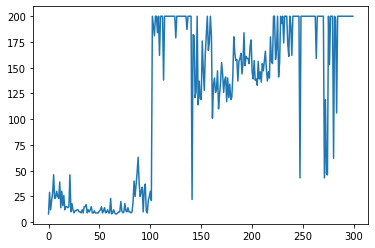

In [42]:
plt.plot(reward_histrory)

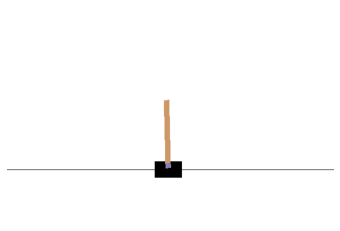

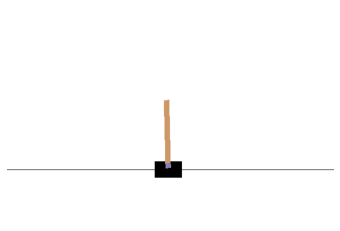

In [43]:
agent.epsilon = 0 #greedy policy
state = env.reset()
done = False
total_reward = 0
cnt = 0

while not done:
  action = agent.get_action(state)
  next_state, reward, done, info, = env.step(action)
  state = next_state
  total_reward += reward
  env_gnw = gnwrapper.Animation(env) # Xvfbが起動される
  env_gnw.render() # ここで、前の描画を消し、新しいステップの描画を行う。
  cnt += 1
  if cnt > 10:
    done = True

In [44]:
print('Total Reward:', total_reward)

Total Reward: 11.0


## 8.3 DQNとAtari
DQN:2013年に発表、2015年にNatureに掲載。
Atari：コンピュータゲームを制作する会社の名前

### 8.3.1 Atariのゲーム環境
Atariを利用するには、別途インストールが必要。  

### 8.3.2 前処理
強化学習の理論は、マルコフ決定過程を前提。  
ゲームの場合、前状態が必要となる。  
このような問題はPOMDP(部分観測マルコフ決定過程：Partially Observable Markov Decision Process）と言う。  

DQNの論文では、４フレームの連続する画像を重ね合わせ、それを一つの「状態」として扱う。連続する画像を扱うことで、状態の遷移が分かる。これで今まで通りMDPとして扱う。  

POMDPで有力な手法はRNNを使った手法。RNNを用いると、過去に入力されたデータを引き継いで計算することができる。  

DQNの論文では、フレームを重ねる前に以下の固定の処理を実施。
- 画像の周囲をトリミング
- グレイスケールへの変換
- 画像のリサイズ
- 正規化  
これらの処理を行った上で、フレームを4つ重ねる作業を行う。

### 8.3.3 CNN
カートポールでは、全結合層からなるNNを使った。  
Atariのような画像データを扱う場合にはCNNが有効。  
DQNの論文では、図8-11の構造が使われた。

### 8.3.4 その他の工夫
- GPUの使用：画像データを扱う場合、データサイズが大きくなり、学習に要する計算量も大きくなる。この計算を高速化するには、GPU（やTPU）などを使って並列計算を行うことが有効。
- εの調整：初期の段階では、エージェントに多くの探索を行わせ、学習が進に連れて探索を減らす。ε-greedy法でこのアイデアを実現するためには、エージェントが行動を重ねるに従ってεを減らす。  
DQNの論文では、最初の100万ステップはεを１.０から０.１まで線形に減少させ、それ以降はε=0.1で固定する方式が採用された。
- 報酬クリッピング：DQNの論文では、報酬を-1.0~1.0の範囲に収まるように調整し、報酬のスケールを揃えることで学習を円滑化している。  

## 8.4 DQNの拡張

### 8.4.1　Double DQN
DQNでは、TDターゲットに近づけるように学習する。  
ここで問題になるのが、誤差が含まれる推定値Qθ'に対してmax演算子を使うと、真のQ関数を使って計算する場合に比べて過大に評価されてしまう。  
この問題を解決するのがDouble DQN。Double DQNでは別のQ関数を使って最大となる行動を選べ、実際の値はQθ'から取得する。このような2つのQ関数を使い分けることで、過大評価が解消され、学習が安定する。

### 8.4.2 優先度付き経験再生
優先度付き経験再生：経験データをランダムに選ぶのではなく、優先度に応じて選ぶ。
TDターゲットであるRt+rmaxQθ'(St+1, a)とQθ(St, At)の差分を取り、絶対値を求めてδtとする。δtが大きければ、それだけ修正すべきことが大きい、つまり、学ぶことが大きい。

### 8.4.3 Dueling DQN
Dueling DQN：NNの構造を工夫した手法。この手法でキーとなるのが、アドバンテージ構造。  
Aπ(s,a) = Qπ(s,a)-Vπ(s)
- Qπ(s,a)：状態sにおいて、「特定の行動a」を行い、それ以降はπに従って行動したときに得られる収益の期待値
- Vπ(s)：状態sにおいて以降すべて方策πに従って行動したときに得られる収益の期待値  
つまり、両者の違いは、状態sにおいて行動aを行うか、それとも方策πに従って行動を選ぶかの違い。アドバンテージ関数は、「aという行動」が「方策πで選ばれる行動」に比べてどれだけ良いかを示す指標と解釈できる。  
アドバンテージ関数と価値関数に枝分かれして学習し、最後に加算する。  
Qπ(s,a) = Aπ(s,a) + Vπ(s)  
このように学習する利点：行動に関わらず結果が決まっている状態であっても、全ての行動を試さなければQ(s,a)が学習されない。一方、Dueling DQNは行動を考慮しない価値関数V(s)を経由する。それによって、他の行動を試さなくてもQ(s,a)の近似性能が改善する。

## 8.5 まとめ

# 9章 方策勾配法
価値ベースの手法の他に、価値関数を経由せずに方策を直接表す手法もある  
→方策ベースの手法  
方策勾配法：方策をNNなどでモデル化し、勾配を使って方策を最適かする手法を方策


## 9.1 最も単純な方策勾配法
方策勾配法：勾配を使って方策を更新する手法の総称。

### 9.1.1 方策勾配法の導出
πθ(a|s)：方策をNNによりモデル化（全ての重みパラメータをθとする）  
続いて、方策πθを使って目的関数を設定し、目的関数を最大化するパラメータθを見つける→最適化。  
最適化問題
- 損失関数：勾配降下法により最小値を探す
- 目的関数：勾配上昇法により最大値を探す

「状態、行動、報酬」からなる時系列データτ  
τ：軌道  
τ = (S0, A0, R0, S1, A1, R1,・・・,St+1)  
G(τ）：収益  
G(τ）= R0+rR1+r^2R2+・・・+r^TRT  
J(θ)：目的関数  
J(θ）= Er〜πθ［G(τ)］  
目的関数から勾配を求める。  
▽θJ(θ)=▽θEr〜πθ［G(τ)］=略  
更新式は、  
θ←θ+α▽θJ(θ)  
α：学習率  

### 9.1.2 方策勾配法のアルゴリズム
勾配は期待値として表され、この期待値はモンテカルロ法によって求められる。方策πθのエージェントに実際に行動させ、軌道τをn個得たとする。
勾配を全ての時刻で求め、各勾配に重みとして収益G(τ)を掛けて、それらの和を求める。  
収益を掛けることにより、うまく行った場合に、うまく行った分だけ取った行動が強められる。

### 9.1.3 方策勾配法の実装

In [53]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class Policy(Model):
  def __init__(self, action_size):
    super().__init__()
    self.l1 = L.Linear(128)
    self.l2 = L.Linear(action_size)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = F.softmax(self.l2(x))
    return x

In [54]:
class Agent:
  def __init__(self):
    self.gamma = 0.98
    self.lr = 0.0002
    self.action_size = 2

    self.memory = []
    self.pi = Policy(self.action_size)
    self.optimizer = optimizers.Adam(self.lr)
    self.optimizer.setup(self.pi)

  def get_action(self, state):
    state = state[np.newaxis, :]#バッチの軸を追加
    probs = self.pi(state)
    probs = probs[0]
    action =  np.random.choice(len(probs), p=probs.data)
    return action, probs[action]

  def add(self, reward, prob):
    data = (reward, prob)
    self.memory.append(data)

  def update(self):
    self.pi.cleargrads()

    G, loss = 0, 0
    for reward, prob in reversed(self.memory):
      G = reward + self.gamma * G

    for reward, prob in self.memory:
      loss += -F.log(prob) * G

    loss.backward()
    self.optimizer.update()
    self.memory = [] #メモリをリセット

In [55]:
env = gym.make('CartPole-v0')
state = env.reset()
agent = Agent()

action, prob = agent.get_action(state)
print('action:', action)
print('prob:', prob)

G = 100.0 #ダミーの重み
J = G * F.log(prob)
print('J:', J)

#勾配を求める
J.backward()

action: 0
prob: variable(0.5187533770023086)
J: variable(-65.63266975744499)


In [56]:
episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_histrory = []

for episode in range(episodes):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, prob = agent.get_action(state)
    next_state, reward, done, info = env.step(action)

    agent.add(reward, prob)
    state = next_state
    total_reward += reward

  agent.update()
  reward_histrory.append(total_reward)

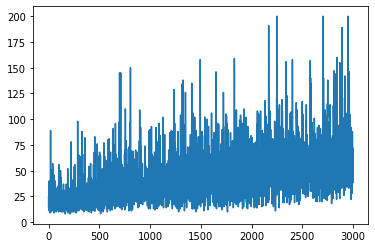

In [58]:
plt.plot(reward_histrory)

## 9.2 REINFORCE
REINFORCE：方策勾配法を改善した手法

### 9.2.1 REINFORCEのアルゴリズム
方策勾配法の重みG(τ)は時刻tよりも前の報酬も含まれる。  
これを以下のように変更し、ノイズを除去する。  
Gt= Rt+rRt+1+・・・+r^T-tRT  


### 9.2.2 REINFORCEの実装

In [59]:
class Agent:
  def __init__(self):
    self.gamma = 0.98
    self.lr = 0.0002
    self.action_size = 2

    self.memory = []
    self.pi = Policy(self.action_size)
    self.optimizer = optimizers.Adam(self.lr)
    self.optimizer.setup(self.pi)

  def get_action(self, state):
    state = state[np.newaxis, :]#バッチの軸を追加
    probs = self.pi(state)
    probs = probs[0]
    action =  np.random.choice(len(probs), p=probs.data)
    return action, probs[action]

  def add(self, reward, prob):
    data = (reward, prob)
    self.memory.append(data)

  def update(self):
    self.pi.cleargrads()

    G, loss = 0, 0
    for reward, prob in reversed(self.memory):
      G = reward + self.gamma * G
      loss += -F.log(prob) * G

    loss.backward()
    self.optimizer.update()
    self.memory = [] #メモリをリセット

In [60]:
episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_histrory = []

for episode in range(episodes):
  state = env.reset()
  done = False
  total_reward = 0

  while not done:
    action, prob = agent.get_action(state)
    next_state, reward, done, info = env.step(action)

    agent.add(reward, prob)
    state = next_state
    total_reward += reward

  agent.update()
  reward_histrory.append(total_reward)

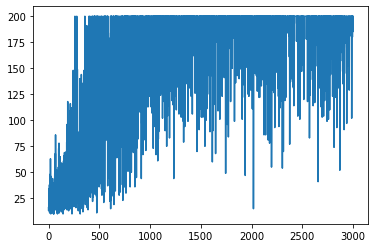

In [61]:
plt.plot(reward_histrory)

## 9.3 ベースライン

### 9.3.1 ベースラインのアイデア
ある結果に対して予測値を引くことで分散を減らすことができる。

### 9.3.2 ベースライン付きの方策勾配法
勾配の式のGtの代わりにGt-b(St)を使うことができる。  
ここでb(St)は任意の関数。  
このb(St)がベースラインと呼ばれる。  
よく用いられるのは価値関数で、b(St)=Vπθ(St)となる。  
ベースラインを使うことで、学習の無駄を省くことができる。

### 9.4 Actor-Critic
Actor-Critic：「価値ベースかつ方策ベース」の手法

### 9.4.1 Actor-Criticの導出
TD法ではGtの代わりにRt+rVw(St+1)を用いる。

### 9.4.2 Actor-Criticの実装

In [62]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

class PolicyNet(Model):
  def __init__(self, action_size=2):
    super().__init__()
    self.l1 = L.Linear(128)
    self.l2 = L.Linear(action_size)

  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = F.softmax(x)
    return x

class ValueNet(Model):
  def __init__(self):
    self.l1 = L.Linear(128)
    self.l2 = L.Linear(1)

    def forward(self, x):
      x = F.relu(self.l1(x))
      x = self.l2(x)
      return x

In [ ]:
class Agent:
  def __init__(self):
    self.gamma = 0.98
    self.lr_pi = 0.0002
    self.lr_v = 0.0005
    self.action_size = 2

    self.pi = PolicyNet()
    self.v = ValueNet()
    self.optimizer_pi = optimizers.Adam(self.lr_pi).setup(self.pi)
    self.optimizer_v = optimizers.Adam(self.lr_v).setup(self.v)
    self.optimizer.setup(self.pi)

  def get_action(self, state):
    state = state[np.newaxis, :]#バッチの軸を追加
    probs = self.pi(state)
    probs = probs[0]
    action =  np.random.choice(len(probs), p=probs.data)
    return action, probs[action]

  def update():
